# Student Performance Regression

**Author:** Jaden W

**Date:** 2026-02-09

**Purpose:** This notebook performs various types of regression on the **Student Test Performance Dataset**. The goal is to evaluate different regression methods and optimize effectiveness in predicting on this particular set of data, guiding future predictive methodologies.

**Dataset:** [Student Performance (Multiple Linear Regression) on Kaggle by N. Narayan](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)

## Contents:

>[1 Data Import and Preprocessing](#1-data-import-and-preprocessing)
- [1.1 Imports & Setup](#11-imports-&-setup)
- [1.2 Dataset Preprocessing](#12-dataset-preprocessing)
- [1.3 Data Inspection](#13-data-inspection)
>[2 Validate Regression Assumptions](#2-validate-regression-assumptions)
- [2.1 Linear Assumption](#21-linear-assumption)
- [2.2 homoscedasticity](#22-homoscedasticity)
[2.3 Normality](#23-normality)
  - [2.3.1 Log Transformation](#231-log-transformation)
  - [2.3.2 Sqrt Transformation](#232-sqrt-transformation)
  - [2.3.3 Boxcox Transformation](#233-boxcox-transformation)
- [2.4 Multicollinearity](#24-multicollinearity)
>[3 Regression](#3-regression)
- [3.1 Linear Regression](#31-linear-regression)
- [3.2 Linear Regression with Pipeline](#32-linear-regression-with-pipeline)
- [3.3 Single-Feature Linear Regression](#33-single-feature-linear-regresssion)
>[4 Polynomial Regression](#4-polynomial-regression)
- [4.1 Polynomial Regression with GridSearchCV](#41-polynomial-regression-with-gridsearchcv)
- [4.2 Single-Feature Polynomial Regression with GridSearchCV](#42-single-feature-polynomial-regression-with-gridsearchcv)
>[5 K Fold](#5-k-fold)
- [5.1 K Fold as Cross Validation](#51-k-fold-as-cross-validation)
- [5.2 K Fold with cross_val_score](#52-k-fold-with-cross_val_score)
- [5.3 K Fold as a Pipeline](#53-k-fold-as-a-pipeline)
>[6 L1 and L2 Regularization](#6-l1-and-l2-regularization)
- [6.1 Lasso Regression](#61-lasso-regression)
- [6.2 Lasso Regression with Polynomial Feature Engineering](#62-lasso-regression-with-polynomial-feature-engineering)
- [6.3 Lasso Regression with Pipeline](#63-lasso-regression-with-pipeline)
- [6.4 Ridge Regression](#64-ridge-regression)
- [6.5 Ridge Regression with GridSearchCV](#65-ridge-regression-with-gridsearchcv)

## 1 Data Import and Preprocessing
### 1.1 Imports & Setup
Imports core libraries for data handling, visualization, statistical analysis and machine learning.

In [50]:
# Utilities
from tqdm import tqdm
from itertools import accumulate
import os

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.style as style

# Staistical tools
from scipy import stats
from scipy.stats.mstats import normaltest
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Kaggle integration
import kagglehub

# Sklearn machine learning
import sklearn
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures, MinMaxScaler, scale, Normalizer)
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso, Ridge)
from sklearn.metrics import (r2_score, mean_squared_error)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score)
from sklearn.feature_selection import SelectKBest, f_regression

Load dataset from Kaggle and read into a pandas dataframe.

In [51]:
path = kagglehub.dataset_download("nikhil7280/student-performance-multiple-linear-regression")
csv_file = os.path.join(path, "student_performance.csv")
df = pd.read_csv(csv_file)

Define `random_state`.

In [52]:
random_state = 6767

### 1.2 Dataset Preprocessing
Preview data.

In [53]:
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0


Check for any null values.

In [54]:
df.isnull().sum()

Hours Studied                       0
Previous Scores                     0
Extracurricular Activities          0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

Encode `Extracurricular Activities`.

In [55]:
df["Extracurricular Activities"] = df["Extracurricular Activities"].str.strip()  # remove leading/trailing spaces
df["Extracurricular Activities"] = df["Extracurricular Activities"].map({"Yes": 1, "No": 0})

df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,1,9,1,91.0
1,4,82,0,4,2,65.0
2,8,51,1,7,2,45.0
3,5,52,1,5,2,36.0
4,7,75,0,8,5,66.0


### 1.3 Data Inspection
Analyze mean, variances and outliers of features relative to `Performance Index`.

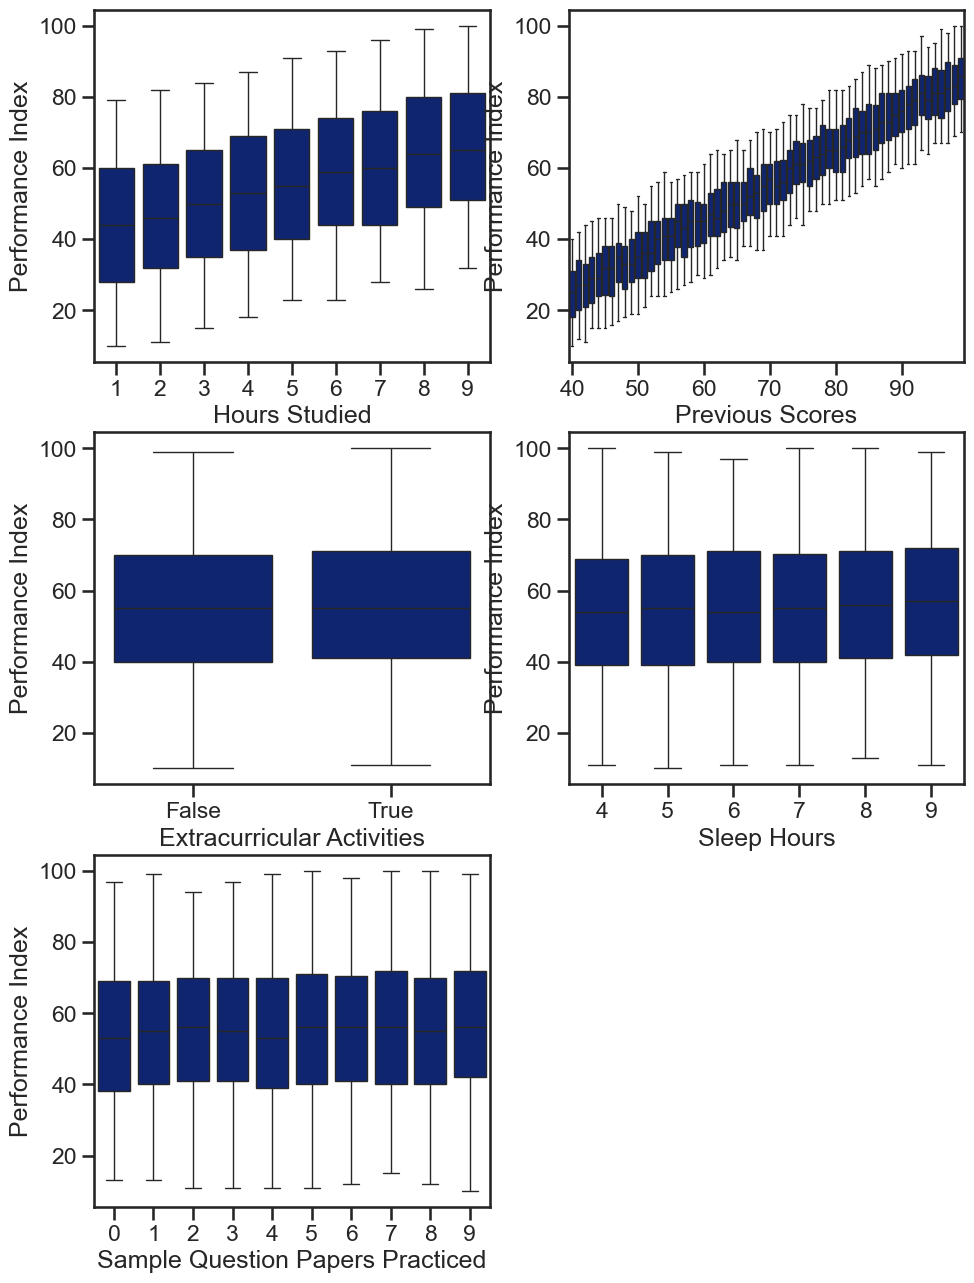

In [56]:
# Create plot figure
plt.figure(figsize=(10,20))

features = [col for col in df.columns if col != "Performance Index"]
axes = [] # store axes objects

for feature in range(len(features)):
    ax = plt.subplot(4,2,feature+1) # create subplot
    sns.boxplot(x = features[feature], y = "Performance Index", data=df, ax=ax)
    axes.append(ax) # save ax

# Update "Previous Scores" X label
ax1_unique_scores = sorted(df["Previous Scores"].unique()) # sort all unique Previous Scores
ax1_tick_positions = list(range(len(ax1_unique_scores)))[::10] # select every 10th position
ax1_tick_labels = [ax1_unique_scores[i] for i in ax1_tick_positions]
axes[1].set_xticks(ax1_tick_positions)
axes[1].set_xticklabels(ax1_tick_labels)

# Update "Extracurricular Activities" X label
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(["False", "True"]);

Analyze features by correlation with `Performance Index`.

In [57]:
# Compute correlation matrix
corr_matrix = df.corr()

# Sort correlations with Performance Index
corr_matrix["Performance Index"]\
    .drop("Performance Index")\
    .sort_values(ascending=False)\
    .to_frame(name="Correlation")

,Correlation
Previous Scores,0.915189
Hours Studied,0.373730
Sleep Hours,0.048106
Sample Question Papers Practiced,0.043268
Extracurricular Activities,0.024525


## 2 Validate Regression Assumptions
### 2.1 Linear Assumption

Linear regression requires the relationship between independent variables and the dependent variable (`Performance Index`) to be linear. This assumption may be tested visually with scatter plots and regression lines.

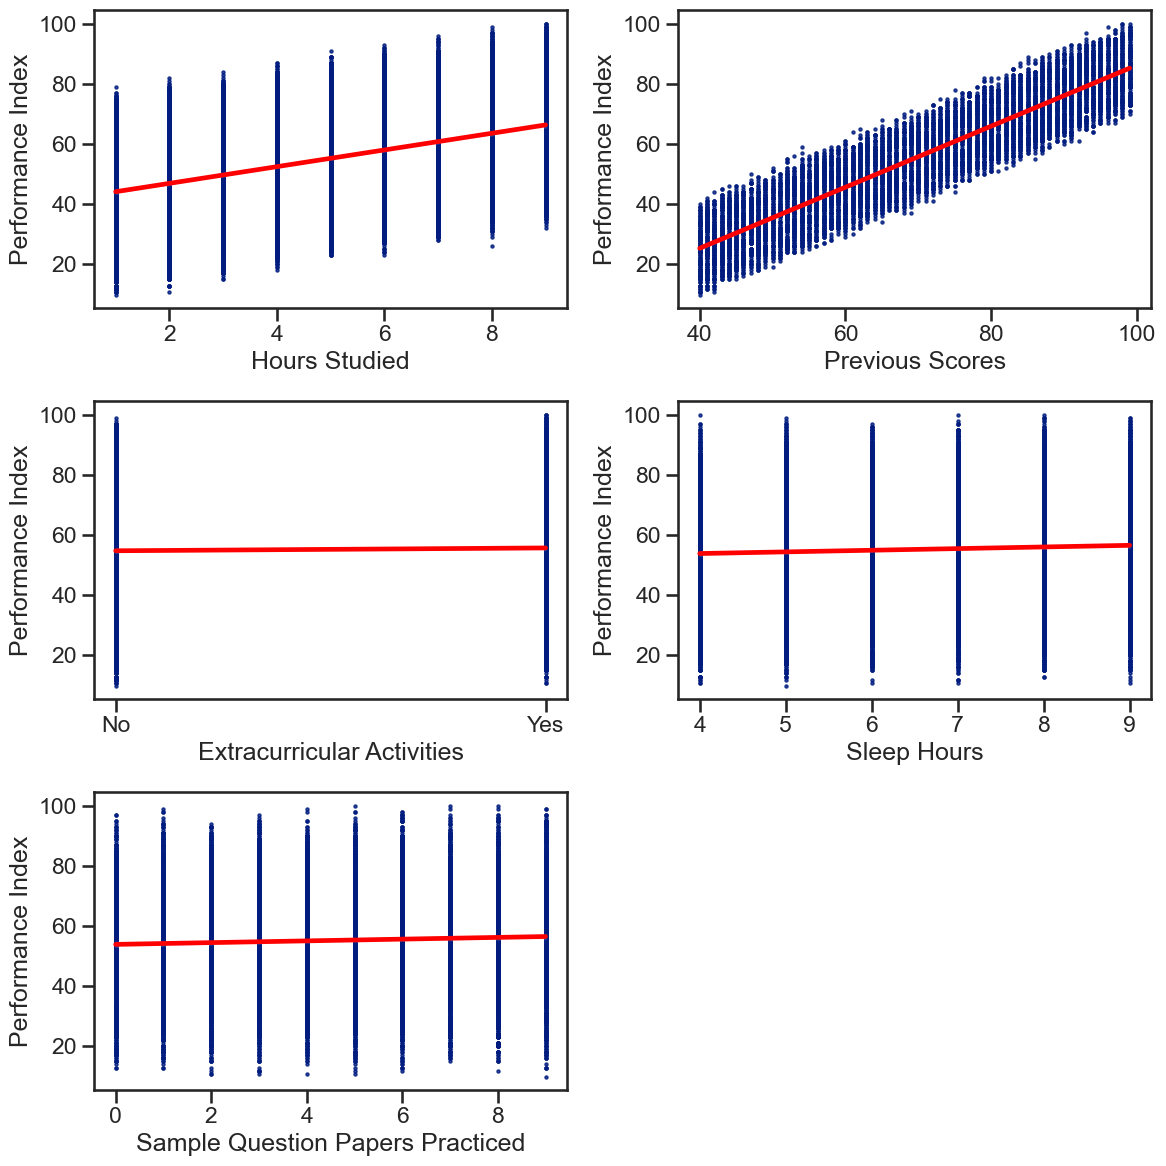

In [59]:
fig, axes = plt.subplots(figsize=(12,12), nrows=3, ncols=2, sharey=False) # 3x2 grid of subplots
positions = [(rows, columns) for rows in range(3) for columns in range(2)] # subplot positions
features = [col for col in df.columns if col != "Performance Index"] # features

# Create regression plots for each feature
for feature, position in zip(features, positions):
    ax = axes[position]
    sns.regplot(x=df[feature],
                y=df["Performance Index"],
                ax=ax,
                scatter_kws={"s": 5},
                line_kws={"color": "red"})

# Customize x-axis for Extracurricular Activities
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(["No", "Yes"])

# Hide empty subplot
axes[2,1].axis("off")

plt.tight_layout()
plt.show()

The plots above depict a dispersed distribution of performances across `Sleep Hours` and `Sample Question Papers Practiced`. However, there is some linear correlation in `Hours Studied` and `Previous Scores`.

### 2.2 Homoscedasticity

The assumption of homocedasticity (constant variance) describes the variance between the independent variables and dependent variable (`Performance Index`) as the same across all values of the independent variable.

This means there is a constant variance present in the response variable (`Performance Index`) as the predictor variable increases.

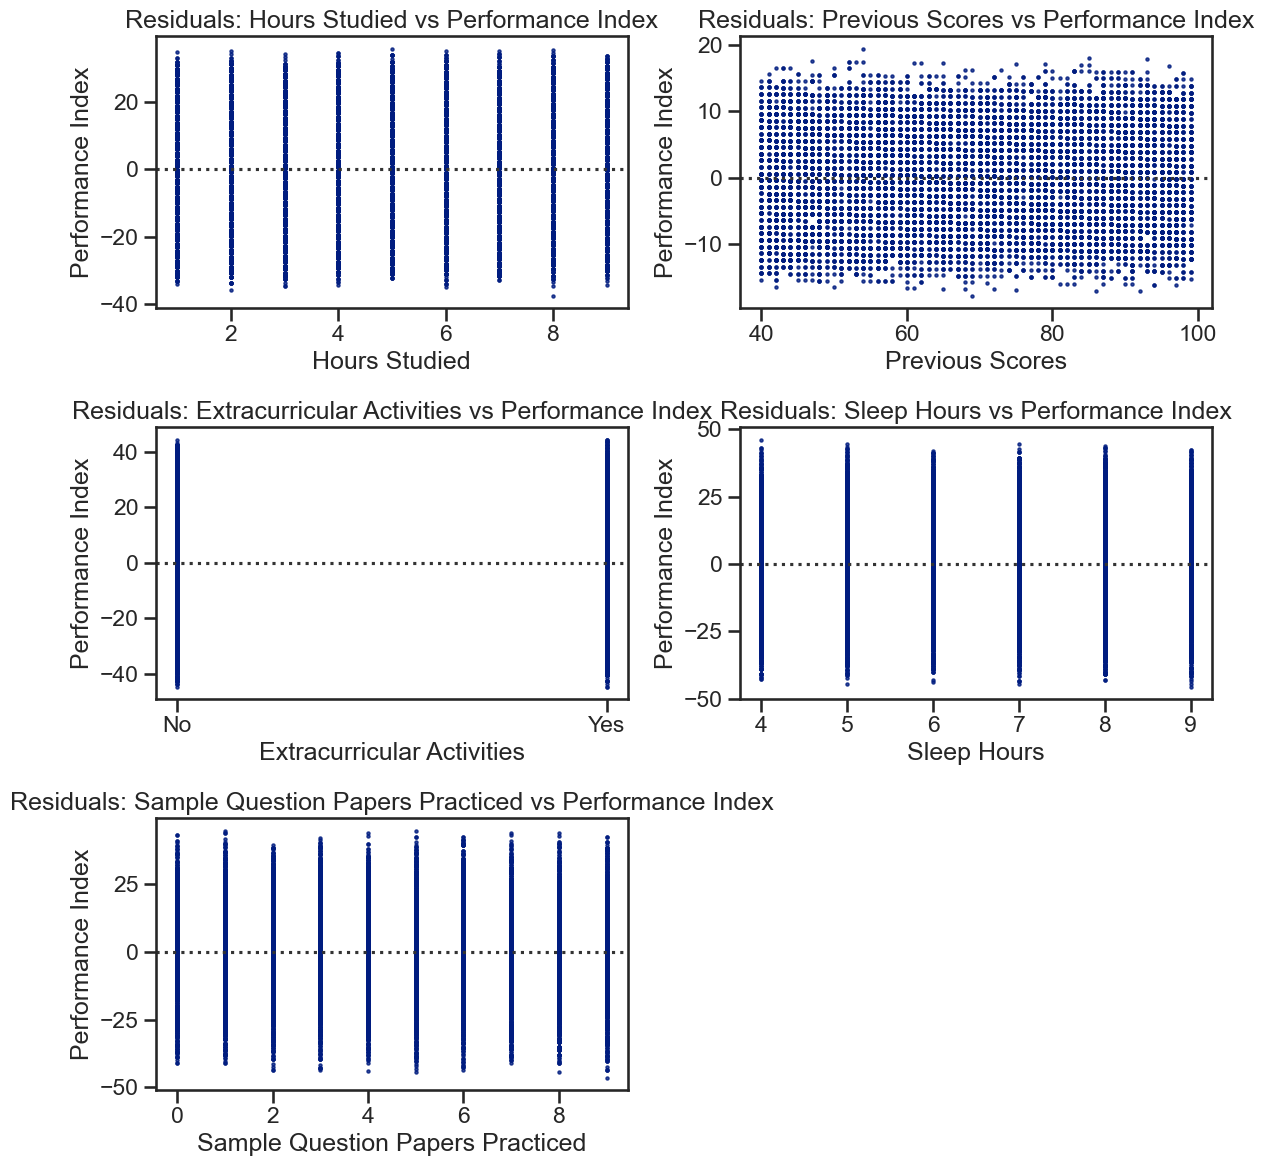

In [61]:
fig, axes = plt.subplots(figsize=(12,12), nrows=3, ncols=2, sharey=False) # 3x2 grid of subplots
positions = [(rows, columns) for rows in range(3) for columns in range(2)] # subplot positions
features = [col for col in df.columns if col != "Performance Index"] # features

# Create residual plots for each feature
for feature, position in zip(features, positions):
    ax = axes[position]
    sns.residplot(x=df[feature], y=df["Performance Index"],
                  ax=ax, scatter_kws={"s":5})
    ax.set_title(f"Residuals: {feature} vs Performance Index")

# Customize x-axis for Extracurricular Activities
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(["No", "Yes"])

# Hide empty subplot
axes[2,1].axis("off")

plt.tight_layout()
plt.show()

The plots above depict a dispersed error variance with no clear structure. Therefore, the assumption of homoscedasticity is not met.

### 2.3 Normality
Linear regression analysis assumes the dependent variable (`Performance Index`) is normally distributed. A histogram, box-plot or a Q-Q-Plot can verify this normal distribution. The goodness of fit test also checks for normality in the dependent variable (`Performance Index`).

In [62]:
def plot_normality_charts(data, feature):
    # Create a customized chart
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    
    # Create the histogram
    ax1 = fig.add_subplot(grid[0,:2])
    ax1.set_title("Histogram")
    sns.histplot(data.loc[:,feature], ax=ax1)

    # Create the QQ_Plot
    ax2 = fig.add_subplot(grid[1,:2])
    ax2.set_title("QQ_plot")
    stats.probplot(data.loc[:,feature], plot=ax2)

    # Create the Box Plot
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title("Box Plot")
    sns.boxplot(data.loc[:,feature], orient="v", ax=ax3)
    

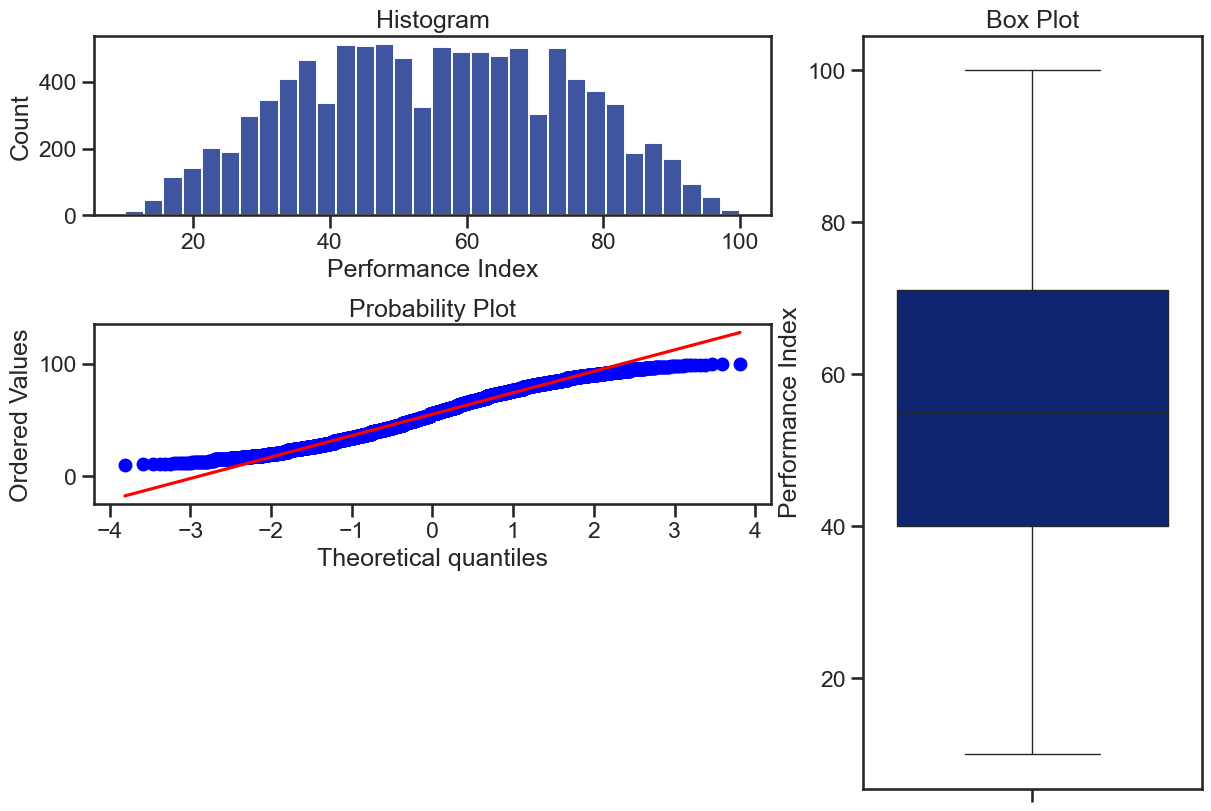

In [63]:

plot_normality_charts(df, "Performance Index")

The three charts above visually tell us that `Performance Index` is not normally distributed.

Also observe normality with a statistical test, using a `p_value`. The higher the `p_value` is the closer the distribution is to being normal.

Frequentist statistics accept a normal distribution (fail to reject the null hypothesis that it is normal) if `p` > `0.05`.

In [64]:
normaltest(df["Performance Index"].values)

NormaltestResult(statistic=np.float64(1130.853463374274), pvalue=np.float64(2.7434086755662947e-246))

The `p-value` is extremely low. The target variable (`Performance Index`) is not normally distributed.

#### 2.3.1 Log Transformation
Use the log transformation to normalize the `Performance Index`.

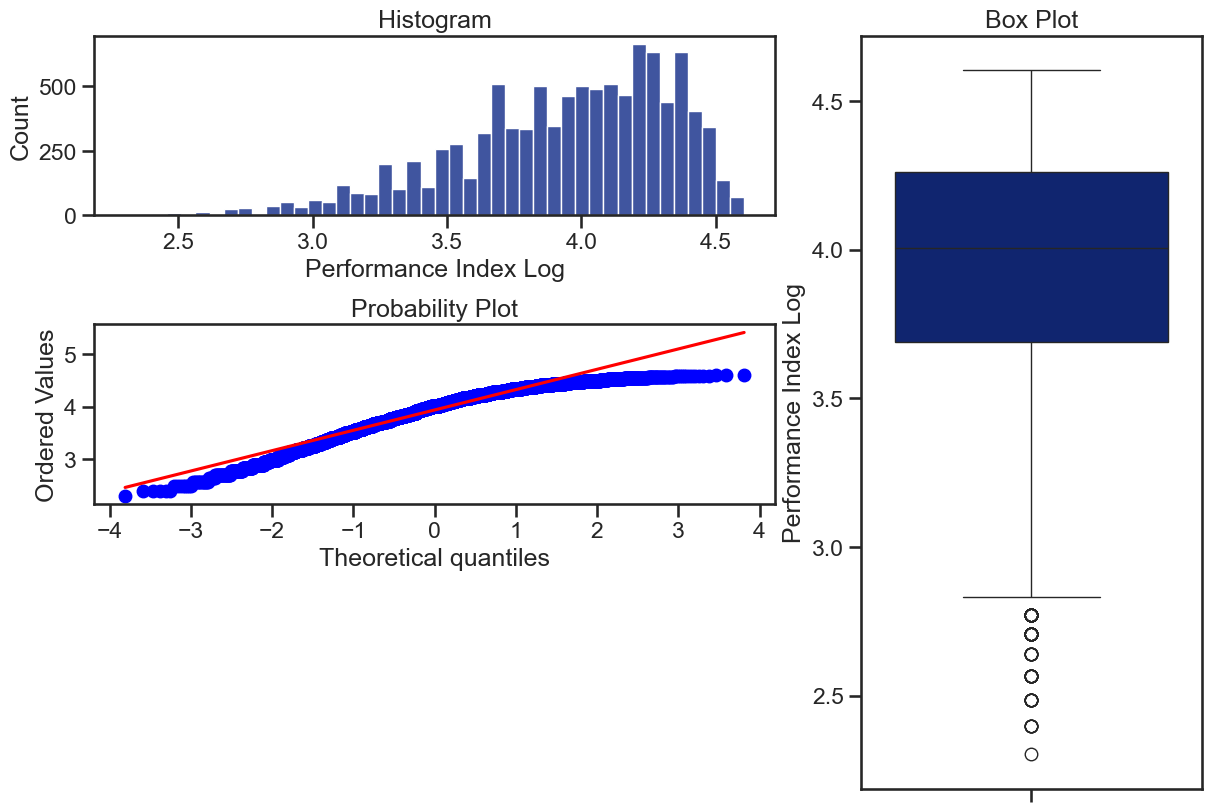

In [65]:
stats_df = pd.DataFrame() # create new statistics dataframe
stats_df["Performance Index Log"] = np.log(df["Performance Index"]) # apply log transformation
plot_normality_charts(stats_df, "Performance Index Log")

In [66]:
normaltest(stats_df["Performance Index Log"])

NormaltestResult(statistic=np.float64(840.915446448985), pvalue=np.float64(2.4976462625712126e-183))

The output is closer to normal distribution. It transformed the `Performance Index` distribution to a more symmetrical curve.

#### 2.3.2 Sqrt Transformation
Use the square root transformation to normalize the `Performance Index`.

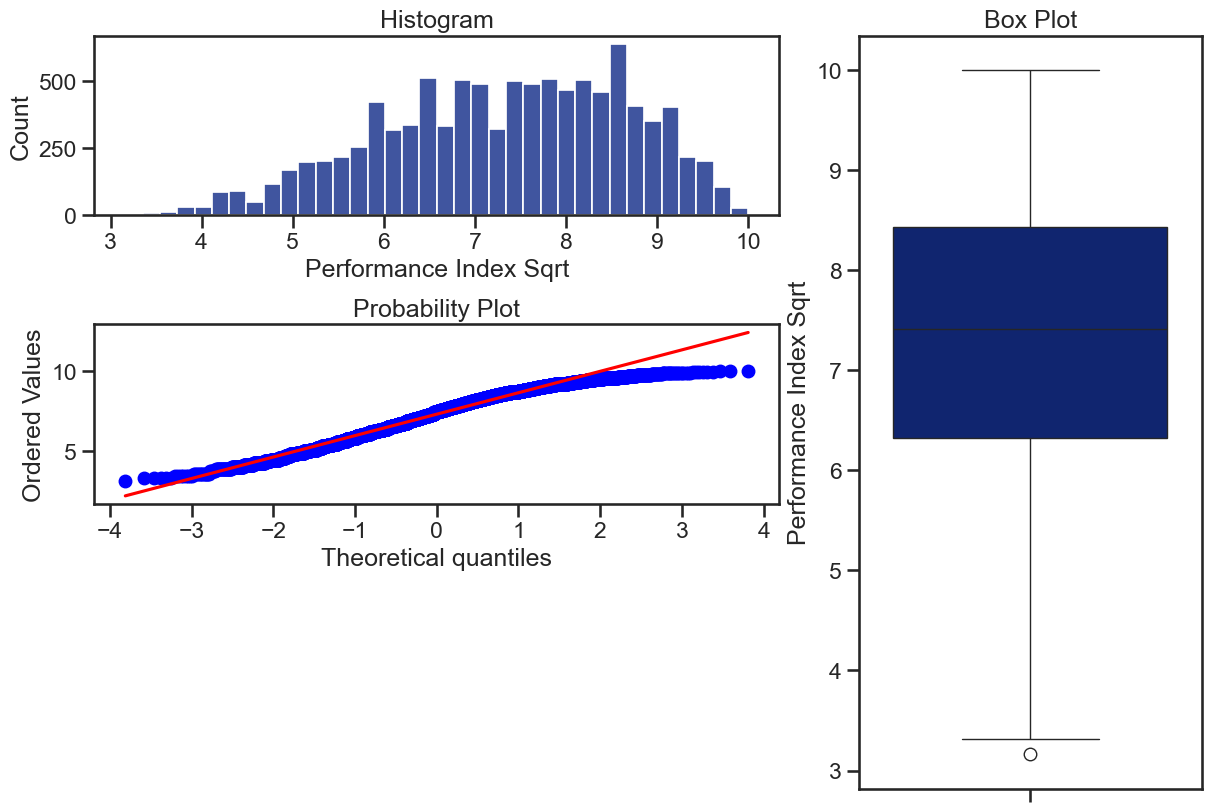

In [67]:
stats_df["Performance Index Sqrt"] = np.sqrt(df["Performance Index"]) # apply sqrt transformation
plot_normality_charts(stats_df, "Performance Index Sqrt")

In [68]:
normaltest(stats_df["Performance Index Sqrt"])

NormaltestResult(statistic=np.float64(499.17033016395607), pvalue=np.float64(4.041476333777599e-109))

The output is even closer to normal distribution.

#### 2.3.3 Boxcox Transformation
The boxcox transformation is a generalization of the square root function that optimizes the exponent degree.

Use the boxcox transformation to normalize the `Performance Index`.

The optimized lambda value is 0.8563766988840682.


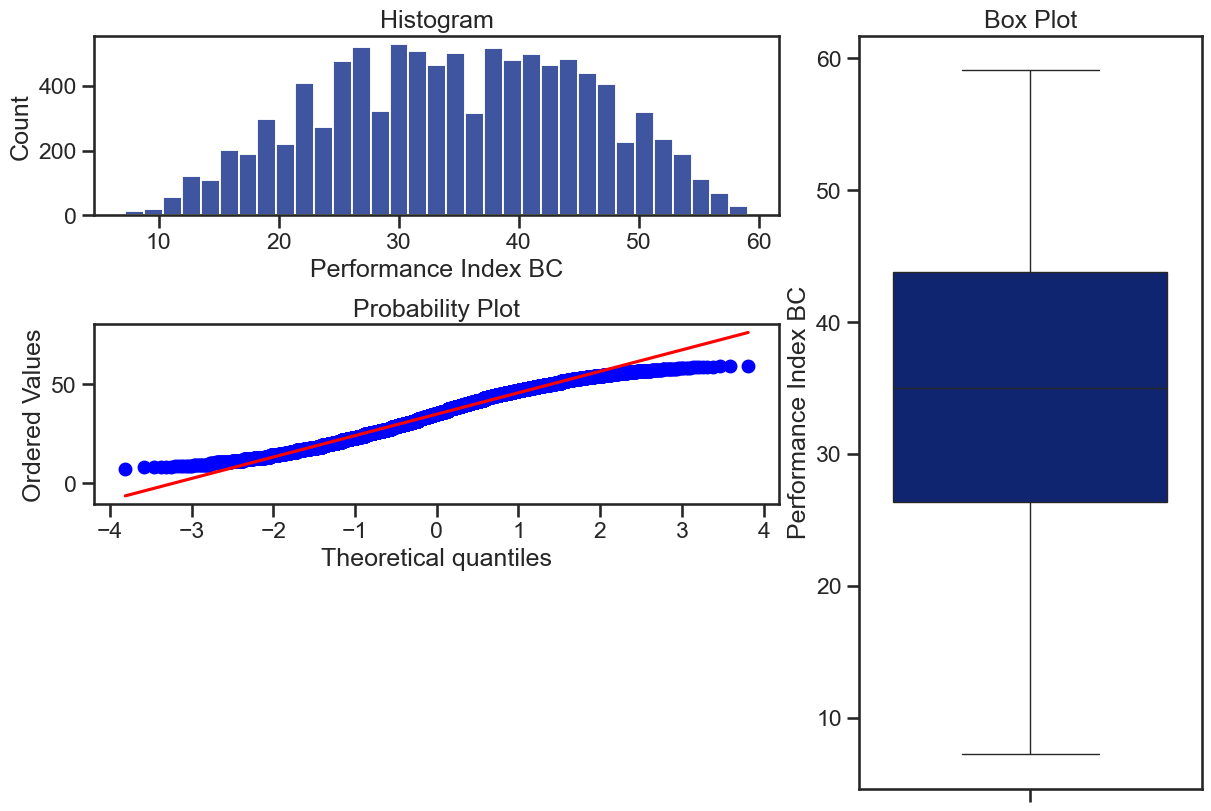

In [69]:
# Compute boxcox values
stats_df["Performance Index BC"], Performance_Index_Lambda = boxcox(df["Performance Index"])

# Print results
print(f"The optimized lambda value is {Performance_Index_Lambda}.")
plot_normality_charts(stats_df, "Performance Index BC")

Also use the inverse boxcox function, and observe the values in a regression context.

In [70]:
print(np.round(inv_boxcox(stats_df["Performance Index BC"], Performance_Index_Lambda),0)[:10])
print(df["Performance Index"].values[:10])

0    91.0
1    65.0
2    45.0
3    36.0
4    66.0
5    61.0
6    63.0
7    42.0
8    61.0
9    69.0
Name: Performance Index BC, dtype: float64
[91. 65. 45. 36. 66. 61. 63. 42. 61. 69.]


In [71]:
print(normaltest(stats_df["Performance Index BC"]))

NormaltestResult(statistic=np.float64(959.0139022648967), pvalue=np.float64(5.65948729000443e-209))


The boxcox results show that it only mildly normalizes the distribution.

We find that the square root transformation is most effective in normalizing our distribution.

### 2.4 Multicollinearity

Multicollinearity occurs when there is a strong correlation between the independent variables. Linear regression requires independent variables to have little or no similar features.

Multicollinearity leads to
- The effect of predictor variables dependent on other variables included in the model
- Predictors being volatile and highly sensitive to small changes in sample
- Inability to interpret a coefficient on a variable because one variable's change leads to a conditional change in another variable

Use a heatmap to identify multicollinearity presence.

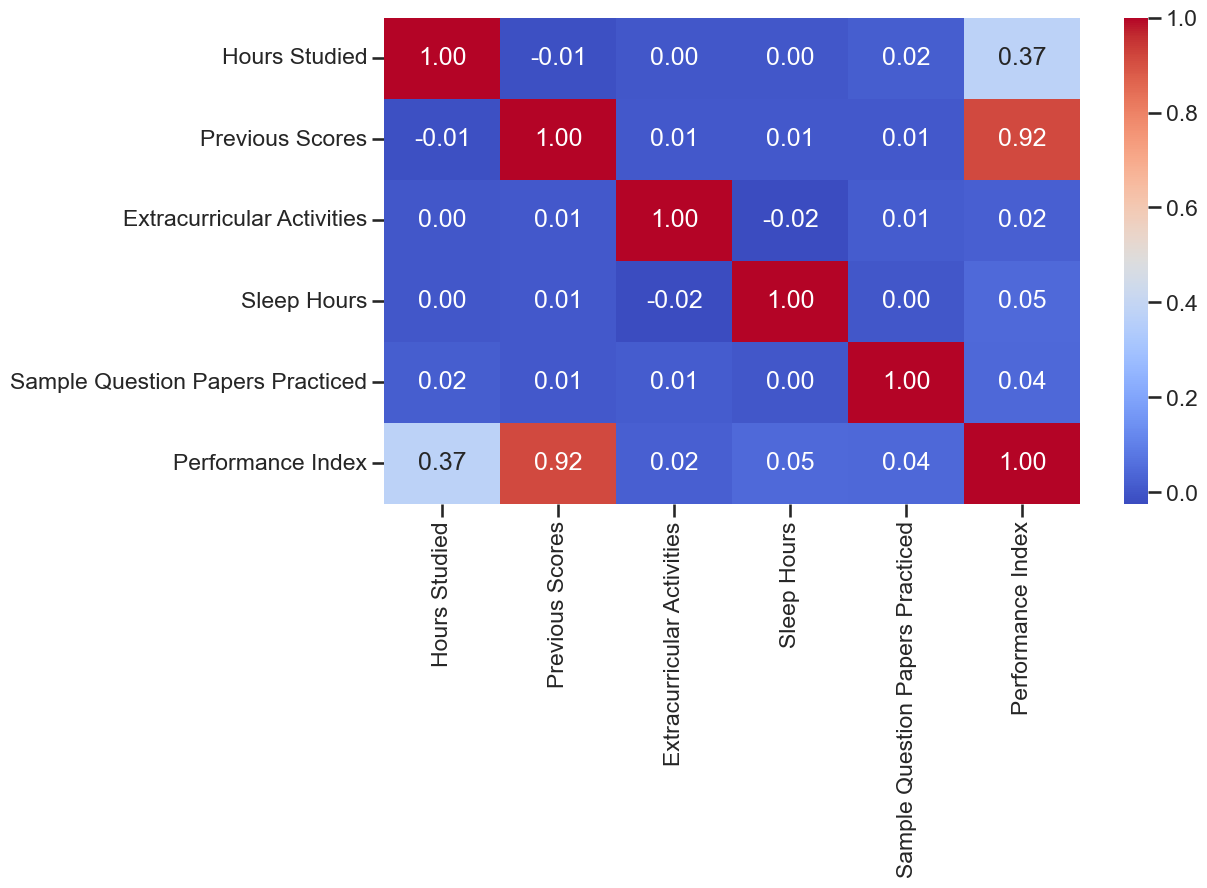

In [72]:
# Create correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

As observable, there is multicollinearity present, though rare and far in-between.

## 3 Regression
### 3.1 Linear Regression
Perform regression using scaled feature variables.

In [73]:
# Define and load predictor (X) and target (y) variables
y_col = "Performance Index"
X = df.drop(y_col, axis=1)
y = df[y_col]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# Noramlize the data using Standard Scaler
s = StandardScaler()
X_train_s = s.fit_transform(X_train)
X_test_s = s.transform(X_test)

# Fit regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)

#Predict on testing data
y_pred = lr.predict(X_test_s)

Now assess the results using the `r2_score`, also known as the goodness of fit of the model, and calculate the accuracy.

In [74]:
print (f"R2 Score: {r2_score(y_test, y_pred)}")
print (f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: 0.9892896478572177
MSE: 3.9933076708869484


That's a high R2 score, signifying accurate model performance.

### 3.2 Linear Regression with Pipeline
Use a `Pipeline` object and apply a set of transformations and linear regression simultaneously, simplifying the steps of processing data.

In [75]:
steps = [("scaler", StandardScaler()), ("lr", LinearRegression())] # define pipeline steps
pipe = Pipeline (steps=steps) # input the list as an argument to the pipeline
pipe.fit(X_train, y_train) # fit the constructor

y_pred = pipe.predict(X_test) # make a prediction

print(f"R2 Score: {r2_score(y_test, y_pred)}") #assess accuracy using R2 Score

#Assess accuracy using RMSE score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print (f"RMSE: {rmse}")

R2 Score: 0.9892896478572177
RMSE: 1.9983262173346343


Plot the predictions vs actual for our pipeline.

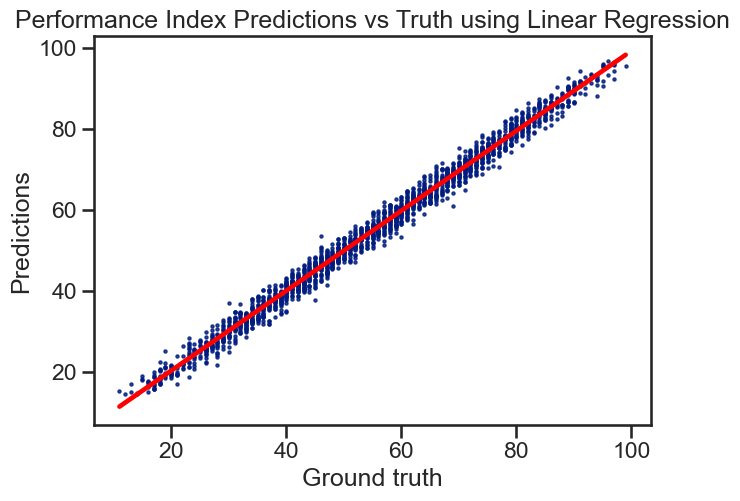

In [76]:
# Configure SNS Style
sns.set_context("talk")
sns.set_style("ticks")
sns.set_palette("dark")

#Build plot
ax = plt.axes()
sns.regplot(x=y_test, y=y_pred, ax=ax, scatter_kws={"s":5}, line_kws={"color":"red"})
ax.set(xlabel="Ground truth",
       ylabel="Predictions",
       title="Performance Index Predictions vs Truth using Linear Regression");

In [77]:
# This function plots the distribution of two inputs
def plot_distribution(actual, predicted):
    plt.figure()

    # Graph actual vs predicted figures
    ax = sns.kdeplot(actual, color="r", label="Actual Value")
    sns.kdeplot(predicted, color="b", label="Fitted Values", ax=ax)

    # Customize plot
    plt.legend()
    plt.title("Actual vs Fitted Values")
    plt.show()
    plt.close()

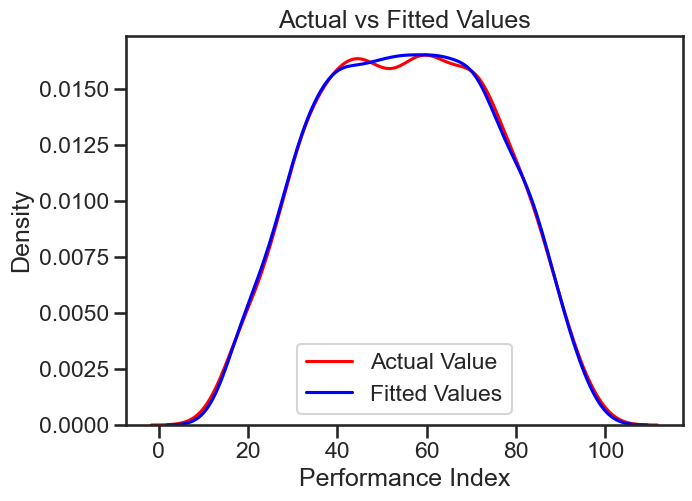

In [78]:
plot_distribution(y_test, y_pred)

In [79]:
# View the estimated coefficients for linear regression
{col:coef for col,coef in zip(X.columns, lr.coef_)}

{'Hours Studied': np.float64(7.376395484217225),
 'Previous Scores': np.float64(17.66012420431953),
 'Extracurricular Activities': np.float64(0.31527489517882146),
 'Sleep Hours': np.float64(0.8002386931196593),
 'Sample Question Papers Practiced': np.float64(0.5340274961865328)}

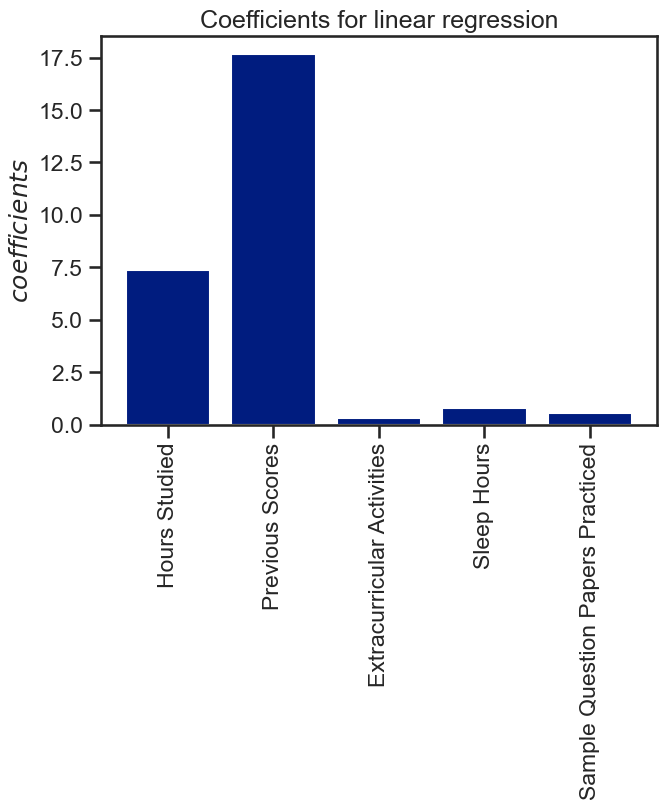

In [80]:
# Plot the estimated coefficients for linear regression
plt.bar(X.columns, abs(lr.coef_[:len(X.columns)]))
plt.xticks(rotation=90)
plt.ylabel("$coefficients$")
plt.title("Coefficients for linear regression")
plt.show()

### 3.3 Single-Feature Linear Regresssion

For each feature, individually train and evaluate the model on the training and test data sets.

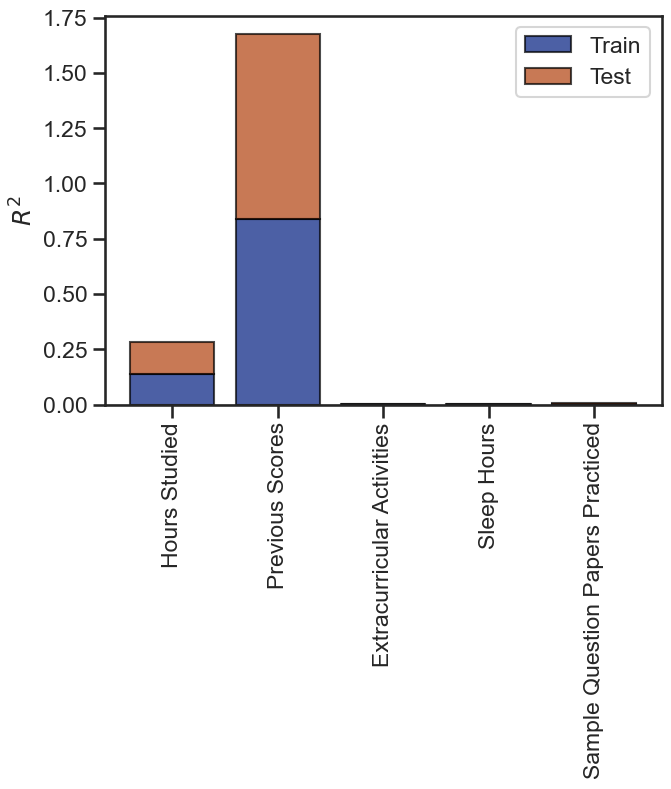

Training R^2 mean value: 0.19597314222993942
Testing R^2 mean value: 0.19805117206887907
Training R^2 max value: 0.8377492983283459
Testing R^2 max value: 0.8368372541263911


In [81]:
features=list(X)
R_2_train=[]
R_2_test=[]

for feature in features:
    # Fit the model
    lr.fit(X_train[[feature]],y_train)
    
    # Evaluate the model
    R_2_train.append(lr.score(X_train[[feature]],y_train))
    R_2_test.append(lr.score(X_test[[feature]],y_test))

# Plot out bars
plt.bar(features,R_2_train,label="Train", alpha=0.7, edgecolor="black")
plt.bar(features,R_2_test,label="Test", bottom=R_2_train, alpha=0.7, edgecolor="black")

# Customize graph
plt.axhline(0, color="black", linewidth=1)
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.legend()
plt.show()

# Display summary
print("Training R^2 mean value: {}\n\
Testing R^2 mean value: {}"
    .format(str(np.mean(R_2_train)),
            str(np.mean(R_2_test))) )

print("Training R^2 max value: {}\n\
Testing R^2 max value: {}"
    .format(str(np.max(R_2_train)),
            str(np.max(R_2_test))))

The plot above depicts that larger co-efficients tend to correspond to a larger `r2_score`.

## 4 Polynomial Regression

A linear model may also be used to fit nonlinear data. This can be performed by adding powers of each feature as new features, and training a linear model on the extended set of features.

When determining model performance, it is important to be weary of overfitting and underfitting.

- Over fitting is when the model is too complex and performs well on trianing data but not on test data. It can be fixed with using methods like regularization.
- Under fitting is when the model is too simple and performs poorly on both data sets. It can be approached with using more complex models like polynomial regression.

### 4.1 Polynomial Regression with GridSearchCV

Use `GridSearch` to optimize the hyper-parameters of the model by using cross-validation.

In [82]:
steps = [("polynomial", PolynomialFeatures(include_bias=False, degree=2)),
         ("scaler", StandardScaler()),
         ("model", LinearRegression())]

pipe = Pipeline(steps=steps)

param_grid = {
    "polynomial__degree": [1,2,3,4], # polynomial degrees
    "model__fit_intercept": [True, False] # whether the model learns a bias term or forces it to pass through the origin
}

scoring = "r2"

cv = 5 # cross-validation folds

n_jobs = 1 # CPU Cores

Create a GridSearchCV object with the dictionary of parameter values to search for the best combination of hyperparameters.

In [83]:
search = GridSearchCV(pipe, param_grid, scoring=scoring, cv=cv, n_jobs=n_jobs)

In [ ]:
search.fit(X_train, y_train) # train GridSearch

,estimator,Pipeline(step...egression())])
,param_grid,"{'model__fit_intercept': [True, False], 'polynomial__degree': [1, 2, ...]}"
,scoring,'r2'
,n_jobs,1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,degree,1


This finds the best parameter values on the training dataset.

Then, obtain the estimator with the best parameters and assign it to a variable.

In [ ]:
best_lr = search.best_estimator_ # determine the best parameters
best_lr

,steps,"[('polynomial', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,1
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


R2 Score: 0.9892896478572177


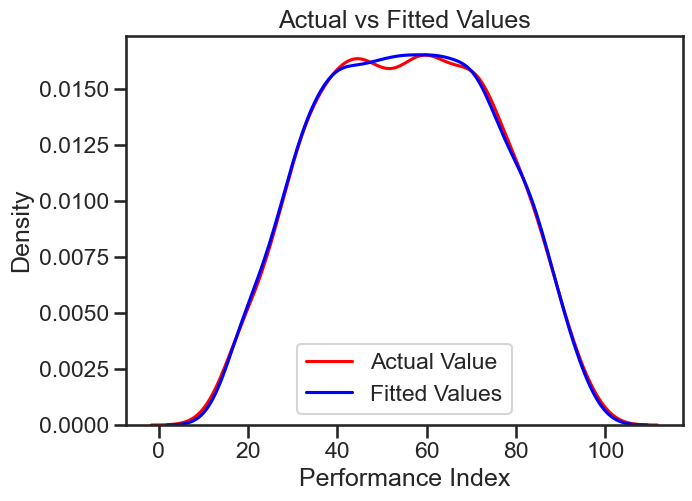

In [ ]:
print ("R2 Score:", best_lr.score(X_test, y_test)) # evaluate the best model
predicted = best_lr.predict(X_test) # fit the model on the test set
plot_distribution(y_test, predicted) # plot distribution against actual values

### 4.2 Single-Feature Polynomial Regression with GridSearchCV

Instead of training multiple regression, perform single-feature regression and calculate `r2 scores`.

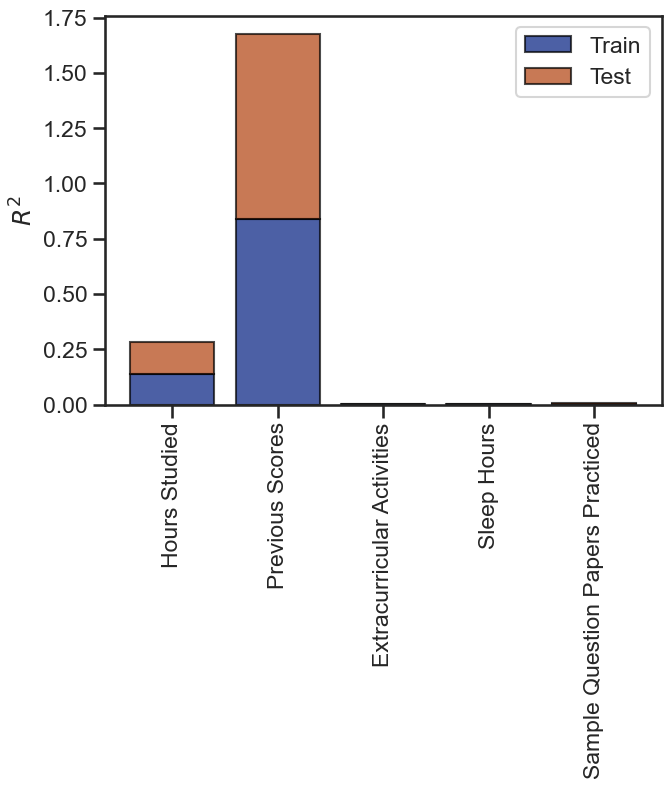

Training R^2 mean value: 0.1959731422299394
Testing R^2 mean value: 0.19805117206887907
Training R^2 max value: 0.8377492983283459
Testing R^2 max value: 0.8368372541263911


In [ ]:
# List all features
features=list(X)

# Store R2 scores for training and testing sets
R_2_train=[]
R_2_test=[]

# Each iteration builds and evaluates a model using only one predictor
for feature in features:
    # Hyperparameters to tune using GridSearchCV
    param_grid = {
    "polynomial__degree": [1,2,3,4,5],
    "model__positive":[True, False]} # forces regression coefficients to be non-negative
    steps = [("polynomial", PolynomialFeatures(include_bias=False,degree=2)), # create nonlinear feature transformations
             ("scaler", StandardScaler()),
             ("model", LinearRegression())]
    pipe=Pipeline(steps)
    n_jobs = 2

    search = GridSearchCV(pipe, param_grid, n_jobs=n_jobs) # Define GridSearchCV

    search.fit(X_train[[feature]],y_train) # Run GridSearhCV

    best_feature = search.best_estimator_ # Extract the best model optimized by GridSearchCV
    
    R_2_train.append(best_feature.score(X_train[[feature]],y_train)) # Evaluate the best approach on training data
    R_2_test.append(best_feature.score(X_test[[feature]],y_test)) # Evaluate the best approach on test data

# Plot stacked bar chart of R2 scores for each feature
plt.bar(features, R_2_train, label="Train", alpha=0.7, edgecolor="black")
plt.bar(features, R_2_test, label="Test", bottom=R_2_train, alpha=0.7, edgecolor="black")

# Customize plot appearance
plt.xticks(rotation=90)
plt.ylabel("$R^2$")
plt.legend()
plt.show()

# Display summary statistics
print("Training R^2 mean value: {}\n\
Testing R^2 mean value: {}"
      .format(str(np.mean(R_2_train)),
              str(np.mean(R_2_test))))
print("Training R^2 max value: {}\n\
Testing R^2 max value: {}"
      .format(str(np.max(R_2_train)),
              str(np.max(R_2_test))))

## 5 K Fold
### 5.1 K Fold as Cross Validation

Using K Fold to perform cross validation and assess how well the model generalizes.

In [ ]:
# Define 3-fold K Fold Cross Validation
n_splits = 3
kf = KFold(shuffle=True, random_state=random_state, n_splits=n_splits)

# Preview the first 10 train/test indices for each split
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:", test_index[:10], len(test_index))
    print("")
    
scores = []

for train_index, test_index in kf.split(X):
    X_train_kf, X_test_kf, y_train_kf, y_test_kf = (X.iloc[train_index, :], # Train test splits
                                        X.iloc[test_index, :],
                                        y[train_index],
                                        y[test_index])
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ])

    pipe.fit(X_train_kf, y_train_kf) # Train pipeline
    y_pred = pipe.predict(X_test_kf)
    score = r2_score(y_test_kf.values, y_pred) # Evaluate model
    scores.append(score)
scores

Train index: [ 0  1  2  4  7  8  9 11 12 13] 6666
Test index: [ 3  5  6 10 17 21 23 26 27 36] 3334

Train index: [ 0  1  2  3  5  6  7  9 10 12] 6667
Test index: [ 4  8 11 18 19 20 22 25 28 29] 3333

Train index: [ 3  4  5  6  8 10 11 17 18 19] 6667
Test index: [ 0  1  2  7  9 12 13 14 15 16] 3333



[0.9887858856883706, 0.9886172447501796, 0.9887229740156729]

### 5.2 K Fold with cross_val_score
K Fold cross validation can also be compressed into a single function.

In [107]:
n_splits = 3
kf = KFold(shuffle=True, random_state=random_state, n_splits=n_splits)

scoring = "r2"
scores = cross_val_score(lr, X, y, scoring=scoring, cv=kf)

def display_scores(scores, print_=False):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(scores)

Scores: [0.98878589 0.98861724 0.98872297]
Mean: 0.988708701484741
Standard deviation: 6.958314145863333e-05


The larger the fold, the more accurate our estimate of the model's performance.

With a higher `k`, each training set contains more data nad each test set is smaller.

This reduces the variance of performance scores across folds, making the average score a more reliable estimate of the model's performance.

In [108]:
# Use Scikit-learn"s K-Fold cross-validation method to assess model performance
kf = KFold(shuffle=True, random_state=random_state, n_splits=50)
scores = cross_val_score(lr, X, y, scoring ="r2", cv=kf)

display_scores(scores)

Scores: [0.99072262 0.9896883  0.99016963 0.98899362 0.98635837 0.99063505
 0.98890937 0.98712049 0.99060611 0.98926573 0.98762408 0.98837801
 0.98831216 0.98803565 0.98846998 0.98614267 0.98762189 0.98974206
 0.98876976 0.98819988 0.98966464 0.98887175 0.98924512 0.98632964
 0.98883224 0.98705673 0.98976873 0.98814939 0.9899185  0.9906163
 0.98731675 0.98609356 0.98898532 0.98882177 0.98765985 0.99164183
 0.9919311  0.9880593  0.99054451 0.98856505 0.98859662 0.98716404
 0.98932373 0.98789086 0.98883524 0.98514482 0.98946932 0.98647998
 0.98897498 0.98743555]
Mean: 0.9886230528651734
Standard deviation: 0.0014557385086942317


### 5.3 K Fold as a Pipeline

We can perform the same function with a pipeline, including the standard scaler.

We"ll use `cross_val_predict` for this, which puts all predictions back into a single array for `r2` evaluation (as opposed to `cross_val_score` separately evaluating each fold).

In [ ]:
# Set parameters
pipe = Pipeline([("scaler", s), ("regression", lr)])
n_splits = 50
kf = KFold(shuffle=True, random_state=random_state, n_splits=n_splits)

# Make predictions
predictions = cross_val_predict(pipe, X, y, cv=kf)

# Print results
print (f"Pipeline R2 score: {r2_score(y, predictions)}\
       \nOriginal R2 Score: {np.mean(scores)}")

Pipeline R2 score: 0.9887405984689962       
Original R2 Score: 0.9886230528651734


Hyperparameter Tuning uses cross validation to determine hyperparameters that generalize well.

## 6 L1 and L2 Regularization
### 6.1 Lasso Regression
Now observe lasso regression, which improves generalization and may predict better on new data. Lasso regression adds L1 regularization, which shrinks less important feature coefficients to zero.

Create an array of numbers equally spaced on a logarithmic scale called `alphas`, which will control regularization strength.

Assess the `r2_score` for each alpha in Lasso Regression.

In [ ]:
alphas = np.geomspace(1e-9, 1e0, num=10)
scores = []
coefs = []

# Define k-fold
n_splits = 3
kf = KFold(shuffle=True, random_state=random_state, n_splits=n_splits)

# Evaluate each alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=100000)
    pipe = Pipeline([
        ("scaler", s),
        ("lasso_regression", lasso)])
    
    predictions = cross_val_predict(pipe, X, y, cv=kf)

    score = r2_score(y, predictions)
    scores.append(score)

list(zip(alphas, scores))

[(np.float64(1e-09), 0.9887116549082707),
 (np.float64(1e-08), 0.9887116549083009),
 (np.float64(1e-07), 0.9887116549090663),
 (np.float64(1e-06), 0.9887116549242111),
 (np.float64(1e-05), 0.9887116550776016),
 (np.float64(0.0001), 0.988711655919941),
 (np.float64(0.001), 0.9887116523837555),
 (np.float64(0.01), 0.9887104210638912),
 (np.float64(0.1), 0.9885785120644379),
 (np.float64(1.0), 0.9803683396349347)]

Examine the individual coefficients for lasso regression.

In [ ]:
dict(zip(X.columns, Lasso(alpha=0.0001).fit(X, y).coef_))

{'Hours Studied': np.float64(2.8529679224985833),
 'Previous Scores': np.float64(1.0184339719745588),
 'Extracurricular Activities': np.float64(0.6124951013841091),
 'Sleep Hours': np.float64(0.4805223356582199),
 'Sample Question Papers Practiced': np.float64(0.1937912171536317)}

Plot the `r2` vs Lasso regularization strength.

Text(0.5, 1.0, 'R2 Score as Alpha Increases')

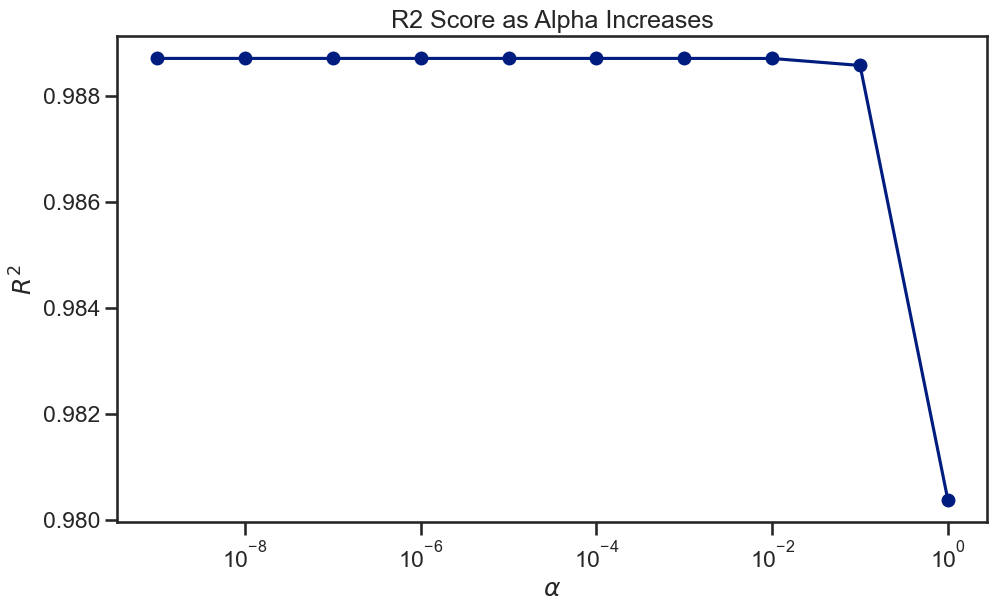

In [118]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, "-o")
plt.xlabel("$\\alpha$")
plt.ylabel("$R^2$");
plt.title("R2 Score as Alpha Increases")

### 6.2 Lasso Regression with Polynomial Feature Engineering
Try lasso on degree-3 polynomials and see `alpha`'s effect on `r2 score`.

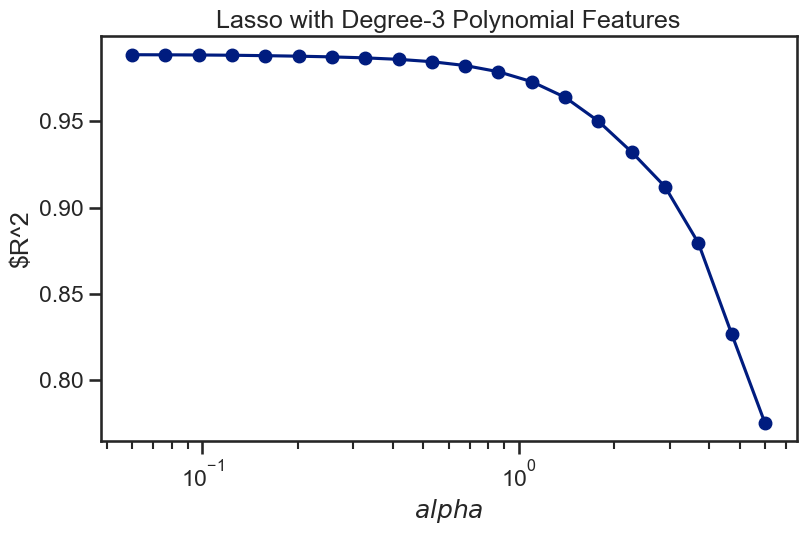

In [ ]:
scores = []

# Define parameters
n_splits = 3
alphas = np.geomspace(0.06, 6.0, 20)

degree = 3
pf = PolynomialFeatures(degree=degree)

kf = KFold(shuffle=True, random_state=random_state, n_splits=n_splits)

for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf), # polynomial feature engineering
        ("lasso_regression", las)])
    predictions = cross_val_predict(estimator, X, y, cv=kf)
    score = r2_score(y, predictions)
    scores.append(score)

# Plot R2 vs alpha
plt.figure(figsize=(8,5))
plt.semilogx(alphas, scores, "-o")
plt.xlabel(r"$alpha$")
plt.ylabel(r"$R^2")
plt.title("Lasso with Degree-3 Polynomial Features");

### 6.3 Lasso Regression with Pipeline
Optimize lasso parameters with a pipeline.

In [120]:
# Define pipeline
best_lasso = Pipeline([
    ("scaler", s),
    ("lasso_regression", Lasso(alpha=0.0001))])

best_lasso.fit(X_train, y_train)

# Print results
print (f"Best estimator score: {best_lasso.score(X_test,y_test)}")

# Print coefficients
coefficients = best_lasso.named_steps["lasso_regression"].coef_
coef_dict = dict(zip(X.columns, coefficients)) # Map them to the feature names
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef}")

Best estimator score: 0.9892895510324387
Hours Studied: 7.376295327341729
Previous Scores: 17.66002447687411
Extracurricular Activities: 0.3151736902048998
Sleep Hours: 0.8001379764380904
Sample Question Papers Practiced: 0.5339303328857381


### 6.4 Ridge Regression

We can also prevent overfitting with Ridge instead of Lasso.

In contrast to Lasso, Ridge never zeros out coefficients, but may add a penalty proportional to the square of the coefficients.

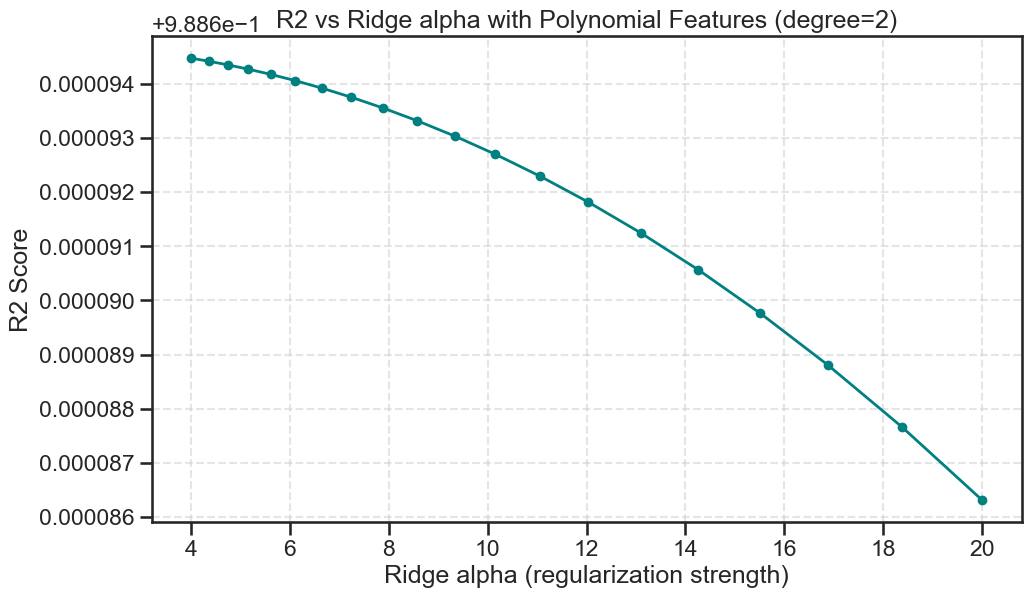

In [ ]:
# Create polynomial features
degree = 2
pf = PolynomialFeatures(degree=degree)

# Define a range of alpha values for Ridge regression
alphas = np.geomspace(4,20,20)

# 3-fold cross-validation
kf = KFold(shuffle=True, random_state=random_state, n_splits=3)

scores = []

for alpha in alphas:
    # Initialize ridge regression
    ridge = Ridge(alpha = alpha, max_iter=100000)

    # Build a pipeline
    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])
    
    # Get cross-validation predictions on the dataset
    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    # Calculate R2 Score
    score = r2_score(y, predictions)
    scores.append(score)

# Plot R2 vs alpha
plt.figure(figsize=(10,6))
plt.plot(alphas, scores, "-o", color="teal", markersize=6, linewidth=2)
plt.xlabel("Ridge alpha (regularization strength)")
plt.ylabel("R2 Score")
plt.title("R2 vs Ridge alpha with Polynomial Features (degree=2)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.ticklabel_format(style="plain", axis="y")
plt.show()

### 6.5 Ridge Regression with GridSearchCV
Use GridSearchCV to optimize hyperparameters.

In [121]:
n_splits = 3

pipe = Pipeline([("scaler", StandardScaler()),
                     ("polynomial_features", PolynomialFeatures()),
                     ("ridge_regression", Ridge())])

params = {
    "polynomial_features__degree" : [1,2,3],
    "ridge_regression__alpha": np.geomspace(4,20,20)
}

kf = KFold(shuffle=True, random_state=random_state, n_splits=n_splits)

search = GridSearchCV(pipe, params, cv=kf)

search.fit(X_train, y_train)

,estimator,"Pipeline(step...n', Ridge())])"
,param_grid,"{'polynomial_features__degree': [1, 2, ...], 'ridge_regression__alpha': array([ 4. ... 20. ])}"
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [101]:
search.best_score_, search.best_params_

(np.float64(0.9885835124716236),
 {'polynomial_features__degree': 1,
  'ridge_regression__alpha': np.float64(4.0)})

In [102]:
y_pred = search.predict(X_test)

r2_score(y_test, y_pred)

0.9892875730903192

Observe the coefficients on each of the features.

In [103]:
features = search.best_estimator_.named_steps["polynomial_features"].get_feature_names_out(X.columns)[1:]
coefficients = search.best_estimator_.named_steps["ridge_regression"].coef_[1:]

coef_dict = dict(zip(features, coefficients))
for feature, coef in coef_dict.items():
    print(f"{feature}: {coef}")

Hours Studied: 7.372580066215685
Previous Scores: 17.65124613385131
Extracurricular Activities: 0.31514434259817614
Sleep Hours: 0.799913695527385
Sample Question Papers Practiced: 0.5338669378024858


Observe the CV results of the gridsearch for every parameter combination, folds included.

In [104]:
import pandas as pd
df = pd.DataFrame(search.cv_results_)
df[["param_polynomial_features__degree", "param_ridge_regression__alpha", "mean_test_score", "rank_test_score"]]

,param_polynomial_features__degree,param_ridge_regression__alpha,mean_test_score,rank_test_score
0,1,4.000000,0.988584,1
1,1,4.353594,0.988583,2
2,1,4.738444,0.988583,3
3,1,5.157315,0.988583,4
4,1,5.613214,0.988583,5
5,1,6.109413,0.988583,6
6,1,6.649475,0.988583,7
7,1,7.237278,0.988582,8
8,1,7.877042,0.988582,9
9,1,8.573360,0.988582,10
